### Airbnb Classification

**Airbnb Business Model**

**Marketplace** that connect people who offers home with peope who wants to rent a home. 

Offert:
* Portfolio Density/Diversity
* Portfolio Size
* Average Price

Demand:
* LTV
* CAC
* Number of Users



**Business Problem**

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

**Data Description**

In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 




**Solution**
1. Predict and load in a database, use data visualization to see results

2. API: 
    * Input: id and customer features
    * Output: id + predict + probability

# 0.0. Load


## 0.1. Imports


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

from scipy import stats as ss
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics 

from keras import models as ml
from keras import layers as l

from scikitplot import metrics as mt

import random


## 0.2. Helper Functions

In [2]:
def num_stats(df):
    num_attributes = df.select_dtypes(['int64', 'float64'])

    #central tendency
    mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    median = pd.DataFrame(num_attributes.apply(np.mean)).T

    #dispersion
    min_ = pd.DataFrame(num_attributes.apply(min)).T
    max_ = pd.DataFrame(num_attributes.apply(max)).T
    range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    skew  = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    std = pd.DataFrame(num_attributes.apply(np.std)).T

    m_numeric = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()

    m_numeric.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m_numeric

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

## 0.3. Load Dataset

In [3]:
df_raw = pd.read_csv('../data/train_users_2.csv', low_memory=True)
df_sessions = pd.read_csv('../data/sessions.csv')

# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [5]:
print('Train dataset:')
print('Rows:{}'.format(df_raw.shape[0]))
print('Cols:{}'.format(df_raw.shape[1]))

print('\nSessions dataset:')
print('Rows:{}'.format(df_sessions.shape[0]))
print('Cols:{}'.format(df_sessions.shape[1]))

Train dataset:
Rows:213451
Cols:16

Sessions dataset:
Rows:10567737
Cols:6


## 1.2. Data Types

In [6]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [7]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [8]:
df1.sample().T

,11444
id,wvcebyc8p2
date_account_created,2011-10-20
timestamp_first_active,20111020213331
date_first_booking,2011-10-21
gender,-unknown-
age,NaN
signup_method,basic
signup_flow,2
language,en
affiliate_channel,sem-non-brand


In [9]:
df_sessions.sample().T

,7630243
user_id,a8iglxkk4h
action,show
action_type,view
action_detail,p3
device_type,Windows Desktop
secs_elapsed,263.0


## 1.2. NA Check

In [10]:
df1.isna().sum()/len(df1)


id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [11]:
df_sessions.isna().sum()/len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.3 Fill NA

In [12]:
#==================Training================
#date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking']=df1['date_first_booking'].fillna(date_first_booking_max)

#age
age_mean = df1['age'].mean()
df1['age'] = df1['age'].fillna(age_mean)

# first_affiliate_tracked
df1['first_affiliate_tracked'] = df1['first_affiliate_tracked'].dropna()

#==================Sessions==============
df_sessions = df_sessions.dropna()


## 1.4. Change Data Type

In [13]:
#date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')
# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])
#age
df1['age'] = df1['age'].astype('int64')



## 1.5. Check Target Distribution

In [14]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

## 1.6. Descriptive Statistics


### 1.6.1. Numerical Users

In [15]:
num_stats(df1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,1.0,2014.0,2013.0,49.392830,49.392830,119.344021,16.210083,263.517271
1,signup_flow,0.0,25.0,25.0,3.267387,3.267387,7.637689,2.234366,3.324444


### 1.6.2. Categorical Users

In [16]:
cat_attributes = df1.select_dtypes('object')
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,213451,213451,213451,213451,213451,207386,213451,213451,213451,213451
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,95688,152897,206314,137727,137426,109232,182717,89600,63845,124543


### 1.6.3. Numerical sessions

In [17]:
num_stats(df_sessions)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,19961.8251,88849.388449,11.137761,154.84312


### 1.6.4. Categorical Sessions

In [18]:
cat_attributes_session = df_sessions.select_dtypes('object').drop('user_id', axis=1)
cat_attributes_session.describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [19]:
#List os cat attributes for cramer v correlation
cat_attributes_list = cat_attributes_session.columns.tolist()

#dict to get all corr (rowxcolumn)
corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list=[]
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        corr = cramer_v(cat_attributes_session[ref], cat_attributes_session[feat])
        corr_list.append(corr)
    corr_dict[ref] = corr_list

In [20]:
corr_df = pd.DataFrame(corr_dict)
corr_df = corr_df.set_index(corr_df.columns)


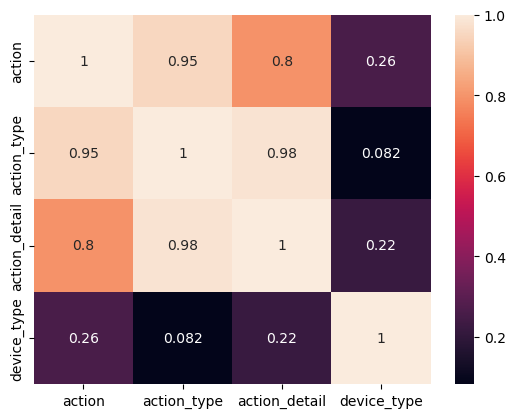

In [21]:
sns.heatmap(corr_df, annot=True);


Conclusion: High correlation between:
* action and action_type
* action and action_detail

# 2.0. Feature Engineering

In [22]:
df2 = df1.copy()

In [23]:
#time between first booking and first active
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2['days_from_active_to_booking'] = (df2['date_first_booking'] - df2['first_active']).dt.days

#time between first booking and account created
df2['days_from_account_created_to_booking'] = (df2['date_first_booking'] - df2['date_account_created']).dt.days

#time between account created and first active
df2['days_from_active_to_account_created'] = (df2['date_account_created'] - df2['first_active']).dt.days

#year  of first active
df2['year_first_active'] = df2['first_active'].dt.year

#month of first active
df2['month_first_active'] = df2['first_active'].dt.month

#day of first active
df2['day_first_active'] = df2['first_active'].dt.day

#day of week of first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

#week of year of first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear


#year  of first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

#month of first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

#day of first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

#day of week of first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

#week of year of first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear


#year  of account created
df2['year_account_created'] = df2['date_account_created'].dt.year

#month of account created
df2['month_account_created'] = df2['date_account_created'].dt.month

#day of account created
df2['day_account_created'] = df2['date_account_created'].dt.day

#day of week of account created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

#week of year of account created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

C:\Users\HeitorFelixdeOliveir\AppData\Local\Temp\ipykernel_18208\3870884473.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
C:\Users\HeitorFelixdeOliveir\AppData\Local\Temp\ipykernel_18208\3870884473.py:40: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
C:\Users\HeitorFelixdeOliveir\AppData\Local\Temp\ipykernel_18208\3870884473.py:56: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


In [24]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,49,facebook,0,en,direct,...,2015,6,29,0,27,2010,6,28,0,26
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,...,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,...,2010,8,2,0,31,2010,9,28,1,39
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,...,2012,9,8,5,36,2011,12,5,0,49
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,...,2010,2,18,3,7,2010,9,14,1,37


# 3.0. Data Filtering

In [25]:
df3= df2.copy()

## 3.1. Filtering Rows

In [26]:
#age greater thaan 15 and lower than 100 - few people
print(len(df3), 'before filter')
df3 = df3[(df3['age']>15) & (df3['age']<100)]
print(len(df3), 'after filter')

213451 before filter
211015 after filter


## 3.2. Columns Selections

# 4.0. Data Preparation

In [27]:
df4 = df3.copy()

### 4.1. Encoding

In [28]:
#dummy variable - signup_method
dummy = pd.get_dummies(df4['signup_method'])
df4 = pd.concat([df4, dummy], axis=1)

# language to binary, either is english or not
df4['language_en'] = np.where(df4['language']=='en', 1, 0)

# signup to binary, either is web or not
df4['signup_on_web'] = np.where(df4['signup_app']== 'Web', 1, 0)

# first_affiliate_tracked to binary, either is tracked or not
df4['tracked'] = np.where(df4['first_affiliate_tracked']=='untracked', 0, 1)

#binary features from first_device_type
df4['first_device_apple'] = np.where(df4['first_device_type'].isin(['Mac Desktop', 'iPhone', 'iPad']), 1 ,0)
df4['first_device_desktop'] = np.where(df4['first_device_type'].isin(['Mac Desktop', 'Desktop', 'Windows Desktop']), 1, 0)

# frequency encoding
affiliate_channel_frequency_encoding = df4['affiliate_channel'].value_counts(normalize=True)
df4['affiliate_channel'] = df4['affiliate_channel'].map(affiliate_channel_frequency_encoding)

affiliate_provider_frequency_encoding = df4['affiliate_provider'].value_counts(normalize=True)
df4['affiliate_provider'] = df4['affiliate_provider'].map(affiliate_provider_frequency_encoding)

first_browser_frequency_encoding = df4['first_browser'].value_counts(normalize=True)
df4['first_browser'] = df4['first_browser'].map(first_browser_frequency_encoding)

### 4.2. Rescaling

In [29]:
from sklearn.preprocessing import MinMaxScaler

# Selecionar as colunas a serem redimensionadas
columns_to_rescale = [
"age",
"signup_flow",
"days_from_active_to_booking",
"days_from_account_created_to_booking",
"days_from_active_to_account_created",
"year_first_active",
"month_first_active",
"day_first_active",
"day_of_week_first_active",
"week_of_year_first_active",
"year_first_booking",
"month_first_booking",
"day_first_booking",
"day_of_week_first_booking",
"week_of_year_first_booking",
"year_account_created",
"month_account_created",
"day_account_created",
"day_of_week_account_created",
"week_of_year_account_created",
]

# Criar uma instância do MinMaxScaler
scaler = MinMaxScaler()

# Redimensionar as colunas selecionadas
df4[columns_to_rescale] = scaler.fit_transform(df4[columns_to_rescale])


# 5.0. Feature Selections

In [30]:
df4.select_dtypes('object').columns

Index(['id', 'gender', 'signup_method', 'language', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'country_destination'],
      dtype='object')

In [31]:
cols_drop = ['gender', 'gender', 'signup_method', 'language', 'first_affiliate_tracked',
       'signup_app', 'first_device_type','date_account_created', 'timestamp_first_active',
             'date_first_booking', 'first_active'] #original dates
df5 = df4.drop(cols_drop, axis=1)

In [32]:
df5.head()

,id,age,signup_flow,affiliate_channel,affiliate_provider,first_browser,country_destination,days_from_active_to_booking,days_from_account_created_to_booking,days_from_active_to_account_created,...,day_of_week_account_created,week_of_year_account_created,basic,facebook,google,language_en,signup_on_web,tracked,first_device_apple,first_device_desktop
0,gxn3p5htnn,0.397590,0.00,0.645381,0.643978,0.299197,NDF,1.000000,0.925957,0.320055,...,0.000000,0.480769,0,1,0,1,1,0,1,1
1,820tgsjxq7,0.265060,0.00,0.040556,0.241926,0.299197,NDF,0.971653,0.785106,0.502747,...,0.333333,0.384615,0,1,0,1,1,0,1,1
2,4ft3gnwmtx,0.481928,0.12,0.645381,0.643978,0.098491,US,0.182730,0.124255,0.326923,...,0.166667,0.730769,1,0,0,1,1,0,0,1
3,bjjt8pjhuk,0.313253,0.00,0.645381,0.643978,0.157505,other,0.454863,0.266809,0.525412,...,0.000000,0.923077,0,1,0,1,1,0,1,1
4,87mebub9p4,0.301205,0.00,0.645381,0.643978,0.299197,US,0.031400,0.060000,0.192308,...,0.166667,0.692308,1,0,0,1,1,0,1,1


In [33]:
X = df5.drop('country_destination', axis=1)
y = df5['country_destination'].copy()

In [34]:
X_train, X_test, y_train, y_test = ms.train_test_split(X,y,test_size=0.2, random_state=32)

# 6.0. Machine Learning Model

In [35]:
weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

## 5.1. Baseline Model

In [36]:
import random

country_destination_list = df4['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
yhat_random = random.choices(population=country_destination_list, k=k_num, weights=weights)

## 5.2. Neural Network - MLP

In [37]:
#split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [38]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)



In [39]:
x_train.head()

,age,signup_flow,affiliate_channel,affiliate_provider,first_browser,days_from_active_to_booking,days_from_account_created_to_booking,days_from_active_to_account_created,year_first_active,month_first_active,...,day_of_week_account_created,week_of_year_account_created,basic,facebook,google,language_en,signup_on_web,tracked,first_device_apple,first_device_desktop
103399,0.397590,0.00,0.645381,0.643978,0.299197,0.291758,0.433191,0.0,0.8,0.636364,...,0.500000,0.653846,1,0,0,1,1,0,1,1
5438,0.493976,0.12,0.645381,0.643978,0.299197,0.000436,0.148936,0.0,0.4,0.454545,...,0.000000,0.423077,1,0,0,1,1,1,1,1
22613,0.228916,0.00,0.645381,0.643978,0.090382,0.504143,0.640426,0.0,0.6,0.272727,...,1.000000,0.307692,1,0,0,1,1,0,1,0
27585,0.144578,0.00,0.645381,0.643978,0.299197,0.484518,0.621277,0.0,0.6,0.454545,...,0.333333,0.442308,0,1,0,1,1,0,1,1
63280,0.397590,0.00,0.645381,0.643978,0.098491,0.369821,0.509362,0.0,0.8,0.181818,...,1.000000,0.153846,1,0,0,1,1,0,0,1


In [42]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_test_nn = ohe.fit_transform(y_test.values.reshape(-1,1)).toarray()

In [49]:
#model definition
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

model_path = '../models/model.h5'
if os.path.exists(model_path):
    model = load_model(model_path)
    
else:
    # Definindo o Early Stopping
    early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1] , activation='relu'))
    model.add(l.Dropout(0.2))  # Adicionando camada de dropout com taxa de 20%
    model.add(l.Dense(12, activation='softmax'))

    #model compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #train model
    model.fit(x_train, y_train_nn, epochs=50, validation_data=(x_test, y_test_nn), callbacks=[early_stopping])

    model.save(model_path)

### 5.3 Other Models (LGBMClassifier)

In [59]:
from lightgbm import LGBMClassifier

In [61]:
def evaluate_model(model):
    
    model.fit(x_train, y_train)
    
    yhat = model.predict(x_test)
    
    balanced_acc_random = metrics.balanced_accuracy_score(y_test, yhat)
    print(f'Balanced accuracy score: {balanced_acc_random:.3f}')

    #Kappa
    kappa_random = metrics.cohen_kappa_score(y_test, yhat)
    print(f'Kappa score: {kappa_random:.3f}')

    #Confusion Matrix
    mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

    

Balanced accuracy score: 0.167
Kappa score: 0.766


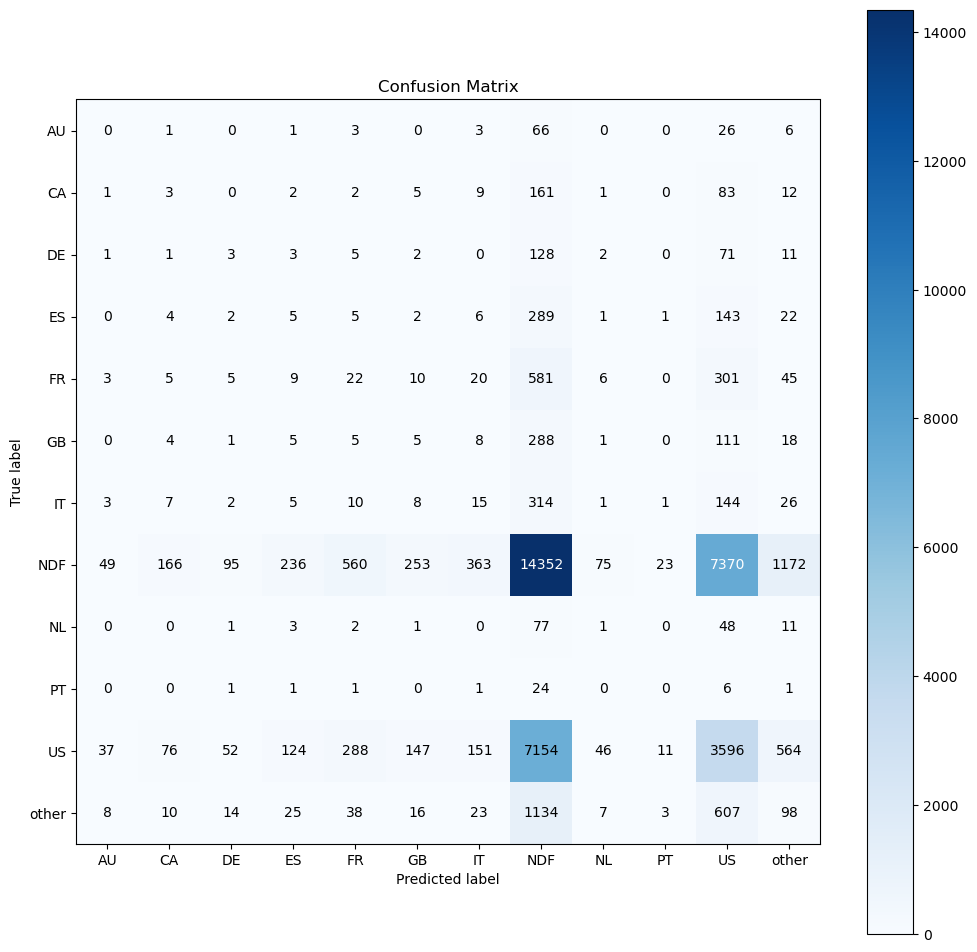

In [63]:
evaluate_model(LGBMClassifier())

# 6.0. Performance

## 6.1. Baseline Performance

Accuracy score: 0.429
Balanced accuracy score: 0.086
Kappa score: -0.002


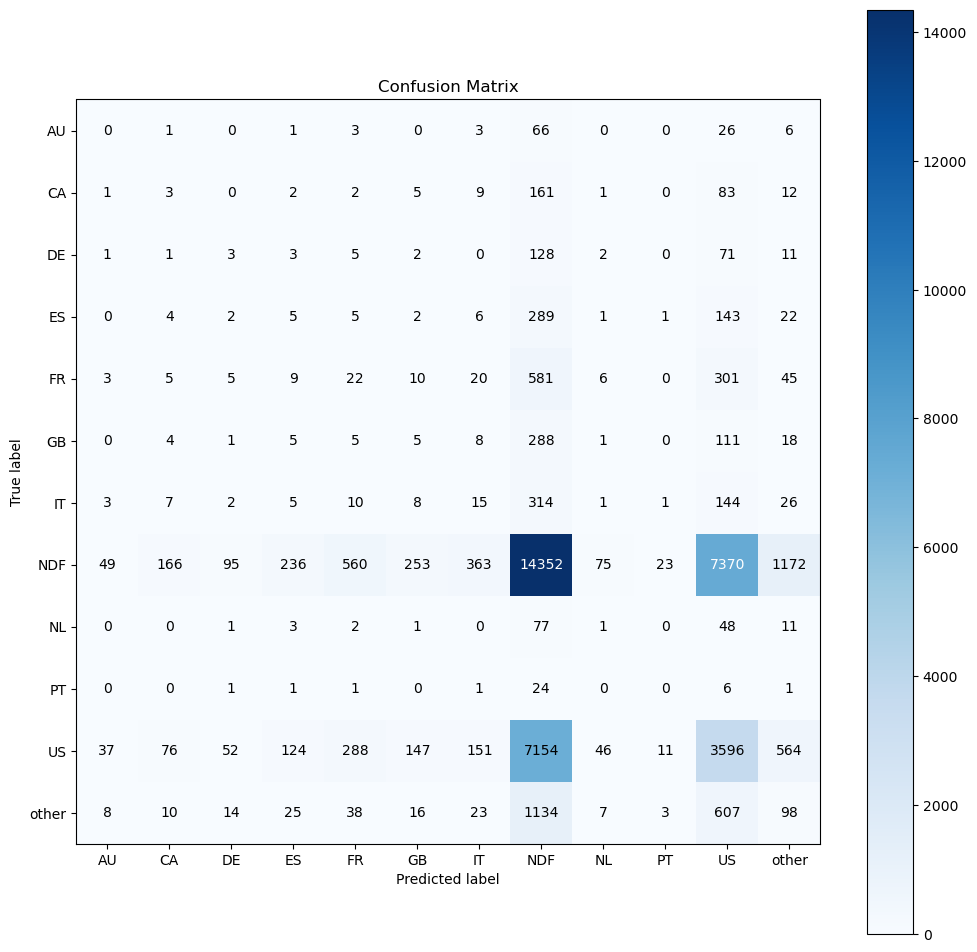

In [51]:
#Accuracy
acc_random = metrics.accuracy_score(y_test, yhat_random)
print(f'Accuracy score: {acc_random:.3f}')

#Balanced accurace
balanced_acc_random = metrics.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced accuracy score: {balanced_acc_random:.3f}')

#Kappa
kappa_random = metrics.cohen_kappa_score(y_test, yhat_random)
print(f'Kappa score: {kappa_random:.3f}')

#Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

## 6.2. NN Performance

In [52]:
#prediction
pred_nn = model.predict(x_test)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

#prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

1319/1319 [==============================] - 1s 954us/step


In [53]:
yhat_nn

array(['NDF', 'NDF', 'NDF', ..., 'NDF', 'NDF', 'NDF'], dtype=object)

Accuracy score: 0.8756249555718788
Balanced accuracy score: 0.16662583700800263
Kappa score: 0.7682968801941187


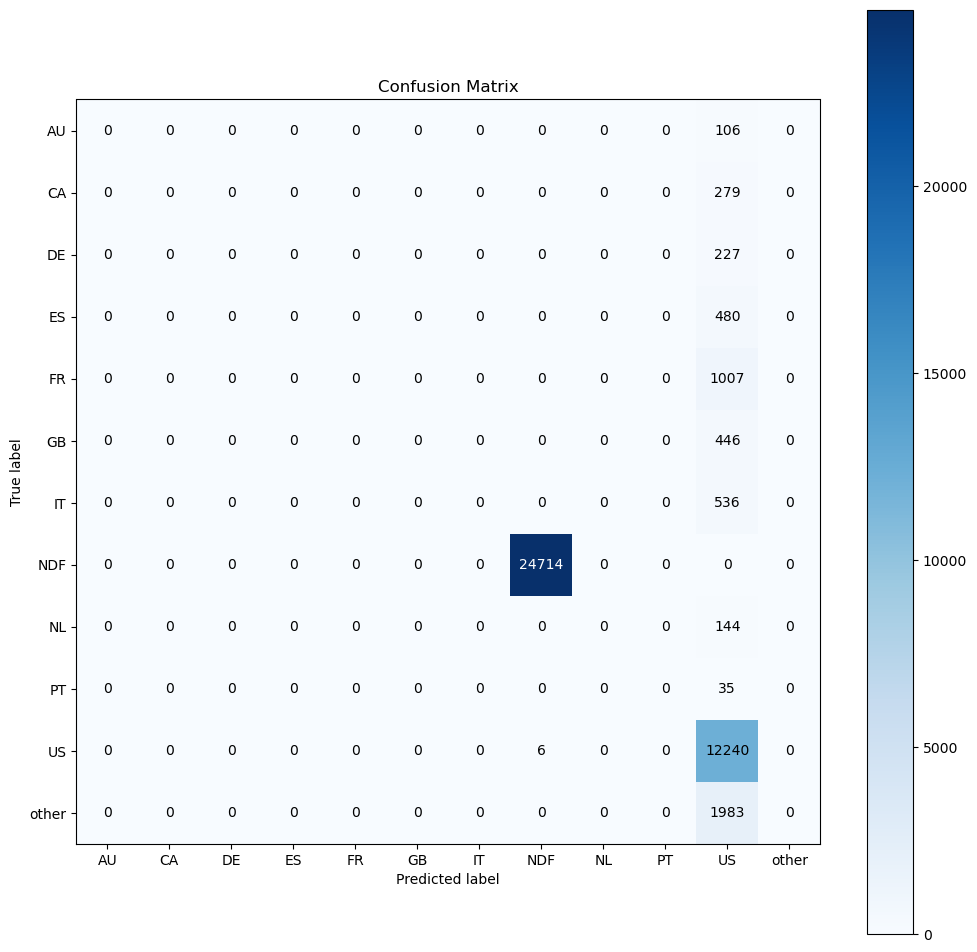

In [54]:
#Accuracy
acc_nn = metrics.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy score: {acc_nn}')


#Balanced accurace
balanced_acc_nn = metrics.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced accuracy score: {balanced_acc_nn}')

#Kappa
kappa_nn = metrics.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa score: {kappa_nn}')

#Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));



In [55]:
pd.Series(yhat_nn).value_counts()

NDF    24720
US     17483
dtype: int64

In [56]:
print(metrics.classification_report(y_test_nn, yhat_nn))

C:\Users\HeitorFelixdeOliveir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HeitorFelixdeOliveir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       106
          CA       0.00      0.00      0.00       279
          DE       0.00      0.00      0.00       227
          ES       0.00      0.00      0.00       480
          FR       0.00      0.00      0.00      1007
          GB       0.00      0.00      0.00       446
          IT       0.00      0.00      0.00       536
         NDF       1.00      1.00      1.00     24714
          NL       0.00      0.00      0.00       144
          PT       0.00      0.00      0.00        35
          US       0.70      1.00      0.82     12246
       other       0.00      0.00      0.00      1983

    accuracy                           0.88     42203
   macro avg       0.14      0.17      0.15     42203
weighted avg       0.79      0.88      0.82     42203



C:\Users\HeitorFelixdeOliveir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
# balanced_acc_list = []
# kappa_list = []

# #stratified kfold
# num_folds=5
# kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# i= 1
# for train_ix, val_ix in kfold.split(x_train, y_train):
#     print('Fold number {}'.format(i))
#     #get fold
#     x_train_fold = x_train.iloc[train_ix]
#     y_train_fold = y_train.iloc[train_ix]
    
#     x_val_fold = x_train.iloc[val_ix]
#     y_val_fold = y_train.iloc[val_ix]
    
#     #one hot enconding
    
#     ohe = pp.OneHotEncoder()
#     y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()
    
    
#     #model definition
#     model = ml.Sequential()
#     model.add(l.Dense(256, input_dim=x_train.shape[1],activation='relu'))
#     model.add(l.Dense(11, activation='softmax'))


#     #model train
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=True)
    
#     #model predict

#     pred_nn = model.predict(x_val_fold)
#     yhat_nn = ohe.inverse_transform(pred_nn)
              
              
#     #prepare data    
#     y_test_nn = y_val_fold.to_numpy()
#     yhat_nn = yhat_nn.reshape(1,-1)[0]
              
              
#     #metrics

#     #balanced accuracy
#     balanced_acc_nn = metrics.balanced_accuracy_score(y_test_nn, yhat_nn)
#     balanced_acc_list.append(balanced_acc_nn)
#     #kappa
              
#     kappa_acc_nn = metrics.cohen_kappa_score(y_test_nn, yhat_nn)
#     kappa_list.append(kappa_acc_nn)
#     i+=1

In [84]:
# print(f'Balanced Accuracy CV = {np.mean(balanced_acc_list)}')
# print(f'Kappa Score CV = {np.mean(kappa_list)}')